## PyTorch CNN model

This code is heavily borrowed from the following sources:
- [MNIST Handwritten Digit Recognition in PyTorch](https://nextjournal.com/gkoehler/pytorch-mnist)
- [PyTorch Convolutional Neural Network With MNIST Dataset](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118)

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:

n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
log_interval = 10
disp_interval = 500

random_seed = 12345
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [3]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda' if cuda else 'cpu')
cuda

True

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets/', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,)),
                               ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets/', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,)),
                               ])),
    batch_size=batch_size_test, shuffle=True
)

C:\Users\vital\miniconda3\envs\jupyter-pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

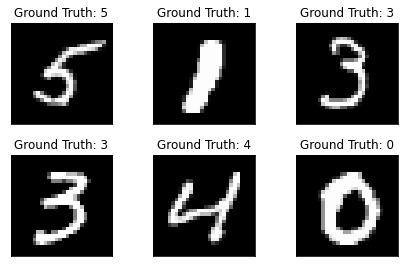

In [6]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(), 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        ) 
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [8]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [9]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [10]:
if cuda:
    model.cuda()
    loss_func.cuda()

In [11]:
def train(num_epochs, model, train_loader, test_loader):
    train_losses, train_counter = [], []
    model.train()
    total_steps = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            b_x = Variable(images.type(Tensor))
            b_y = Variable(labels.to("cuda" if cuda else "cpu"))
            output, x = model(b_x)
            loss = loss_func(output, b_y)

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            
            curr_loss = loss.item()
            
            if (i+1) % log_interval == 0:
                train_losses.append(curr_loss)
                train_counter.append(total_steps * epoch + i + 1)
            if (i+1) % disp_interval == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {curr_loss:.4f}")
    
    os.makedirs(f"models/", exist_ok=True)
    torch.save(model.state_dict(), 'models/model.pth')
    torch.save(optimizer.state_dict(), 'models/optimizer.pth')
    return train_losses, train_counter

In [12]:
train_losses, train_counter = train(n_epochs, model, train_loader, test_loader)

C:\Users\vital\miniconda3\envs\jupyter-pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Step [500/938], Loss: 0.2532
Epoch [2/10], Step [500/938], Loss: 0.1719
Epoch [3/10], Step [500/938], Loss: 0.3243
Epoch [4/10], Step [500/938], Loss: 0.3054
Epoch [5/10], Step [500/938], Loss: 0.0420
Epoch [6/10], Step [500/938], Loss: 0.2427
Epoch [7/10], Step [500/938], Loss: 0.2142
Epoch [8/10], Step [500/938], Loss: 0.2131
Epoch [9/10], Step [500/938], Loss: 0.2238
Epoch [10/10], Step [500/938], Loss: 0.0848


In [13]:
def test(test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = model(images.type(Tensor))
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels.to("cuda" if cuda else "cpu")).sum().item() / float(labels.size(0))
    
    print(f"Accuracy: {accuracy}")

In [14]:
test(test_loader)

Accuracy: 0.989


Text(0, 0.5, 'cross entropy loss')

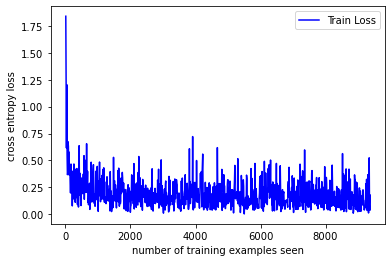

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross entropy loss')

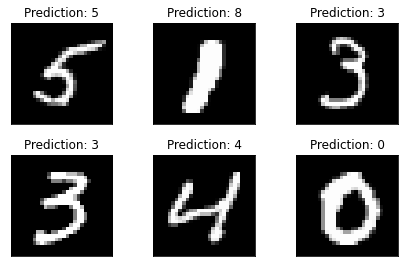

In [40]:
with torch.no_grad():
    output, _ = model(example_data.to("cuda" if cuda else "cpu"))
    
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Prediction: {output.data.max(1, keepdim=True)[1][i].item()}")
    plt.xticks([])
    plt.yticks([])